### Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

### Model Definition

In [2]:
class DecisionTree:
    class Node:
        gNode = None
        def __init__(self, leaf=False, prop=None, path=None, val=None, ent=None):
            self.leaf = leaf
            self.prop = prop
            self.path = path
            self.val = val
            self.ent = ent
    
    
    def __init__(self):
        self.root = None
        self.g = nx.DiGraph()
        self.i = 0
        self.node_labels = {}
        self.edge_labels = {}
        
    
    def fit(self, X, Y):
        _, self.root = self.buildrec(X, Y)
        
    
    def info(self, Y):
        n = len(Y)
        counts = Y.value_counts()
        val = 0.0
        for c in counts.values:
            tmp = c / n
            val += - tmp * np.log2(tmp)
        
        return val
    
    
    def buildrec(self, X, Y):
        nodeval = self.i
        self.i += 1
        
        uniques = Y.unique()
        if len(uniques) == 1:
            self.node_labels[nodeval] = uniques[0]
            return nodeval, self.Node(leaf=True, val=uniques[0], ent=0.0)
        
        least_feature = None
        least_ent = None
        
        for feature in X.columns:
            entropy = 0.0
            for unq in X[feature].unique():
                ind = X[feature] == unq
                X_ = X[ind]
                Y_ = Y[ind]
                
                entropy += (len(Y_) / len(Y)) * self.info(Y_)
                
            if least_feature is None or entropy < least_ent:
                least_feature = feature
                least_ent = entropy
                
        path = {}
        
        for unq in X[least_feature].unique():
            ind = X[least_feature] == unq
            X_ = X[ind]
            Y_ = Y[ind]
            
            childval, tmp = self.buildrec(X_, Y_)
            self.g.add_edge(nodeval, childval)
            self.edge_labels[(nodeval, childval)] = unq
            
            path[unq] = tmp
        
        self.node_labels[nodeval] = least_feature
        return nodeval, self.Node(leaf=False, prop=least_feature, path=path, ent=least_ent)
        
        
    def predict(self, X):
        Y_pred = pd.Series(dtype='object')
        
        for i, x in X.iterrows():
            curr = self.root
            
            while curr.leaf is False:
                curr = curr.path[x[curr.prop]]
            
            Y_pred.loc[i] = curr.val 
        
        return Y_pred
    
    
    def visualize(self):
        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(self.g, pos={0: (0, 0)})
        nx.draw(self.g, pos)
        nx.draw_networkx_nodes(self.g, pos, node_size=1000)
        nx.draw_networkx_labels(self.g, pos, labels=self.node_labels)
        nx.draw_networkx_edge_labels(self.g, pos, edge_labels=self.edge_labels)
        plt.show()

### Dataset Loading

In [3]:
df = pd.read_csv('dataset.csv')

df.head()

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


### Preparing the Dataset for Training

In [4]:
X_train, Y_train = df.drop('Decision', axis=1), df['Decision']

### Training and Testing the model

In [5]:
model = DecisionTree()

model.fit(X_train, Y_train)

### Define the Testing Dataset

In [6]:
X_test = pd.DataFrame({'Outlook': ['Sunny', 'Overcast'],
                       'Temp.': ['Mild', 'Cool'],
                       'Humidity': ['High', 'Normal'],
                       'Wind': ['Weak', 'Strong']})

X_test

,Outlook,Temp.,Humidity,Wind
0,Sunny,Mild,High,Weak
1,Overcast,Cool,Normal,Strong


### Predict the Outcomes

In [7]:
Y_pred = model.predict(X_test)

In [8]:
print('Predictions by the Decision Tree Classifier:')
X_test.assign(Decision=Y_pred)

Predictions by the Decision Tree Classifier:


,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,Mild,High,Weak,No
1,Overcast,Cool,Normal,Strong,Yes


### Decision Tree Visualized

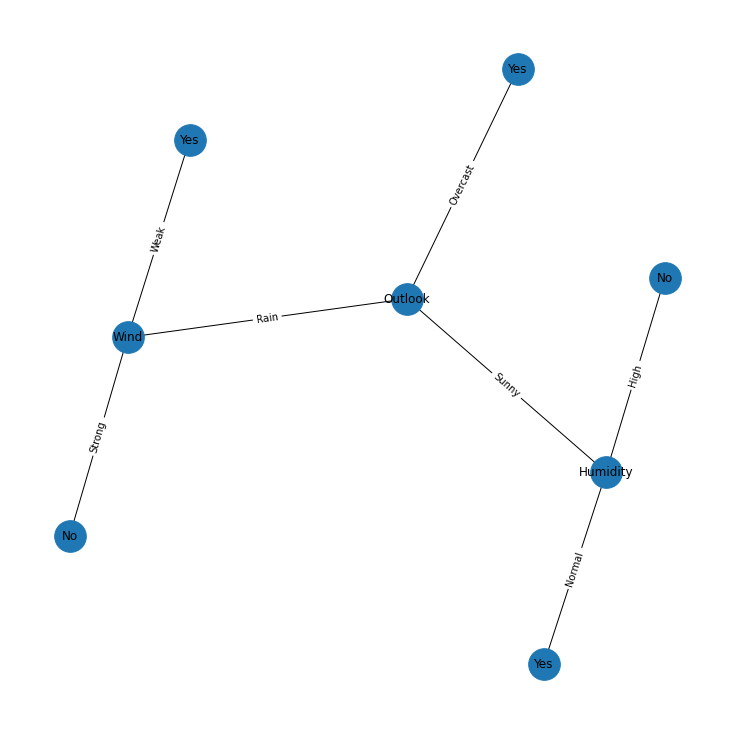

In [9]:
model.visualize()